# Loads
Topfarm supports load constraints by evaluating a trained surrogate model at each iteration. There are currently two different high-level load workflows implemented, namely the Dynamic Wake Meandering (DWM) and the Frandsen approach.
### DWM
In DWM the loads are calculated for all turbines for all flowcases and for all turbine interactions. This means that for each turbine it will look at the wakes coming from all other turbines (individually). The results are subsequently reduced to only one load per turbine by applying a soft max. This is done to create a differentiable expression for the max load instead of just taking the max load, which would not work well in a gradient-based optimization.
### Frandsen
In the Frandsen implementation, the turbulence is aggregated from different sectors with the Wöhler exponent as described in the IEC. Loads are then calculated based on the effective turbulence. Alternatively, if one would like to improve the fidelity by trading off some memory consumption the loads could be calculated based on the all wind direction sectors and subsequently aggregated with the Wöhler exponent.

## Load Surrogates
Topfarm can utilize surrogates trained with a range of different algorithms and softwares, namely scikit-learn, OpenTURNS, TensorFlow and the artificial neural networks code (wind2loads ANN) developed at DTU. 

## Install wind2loads
In this exercisw we will use the wind2loads artificial neural networks code to predict the turbine loads of the DTU 10MW reference turbine.

In [1]:
%%capture
try:
    import w2l
except:
    !pip install --upgrade git+https://gitlab.windenergy.dtu.dk/TOPFARM/wind2loads.git    
try:
    import workshop
except:
    try:
      !git clone https://gitlab.windenergy.dtu.dk/TOPFARM/workshop-december-2019.git
    except:
        pass
    import sys
    !pip install -e ./workshop-december-2019
    sys.path.append('./workshop-december-2019')
try:
    import topfarm
except:
    !pip install topfarm

## Import dependencies

In [2]:
import numpy as np
import topfarm
from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.plotting import XYPlotComp

In [ ]:
import workshop
import os

In [4]:
print(workshop.__file__)

c:\users\usuario\topfarm2\_notebooks\elements\workshop-december-2019\workshop\__init__.py


In [9]:
workshop.w2l_path = 'workshop-december-2019/workshop/wind2loads_ann'
import workshop.workflow as wf

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\usuario\topfarm2\_notebooks\elements\workshop-december-2019\workshop\workflow.py:163: DeprecationWarning: AEPCalculator(wake_model) is deprecated;
wake_model(x_i, y_i, ...) returns a flowModelResult with same functionality as AEPCalculator.
  n_wt = len(initial_positions)


In [42]:
print(wf.__file__)

c:\users\usuario\topfarm2\_notebooks\elements\workshop-december-2019\workshop\workflow.py


In [4]:
!pip install pytest==4.6

  Attempting uninstall: pytest
    Found existing installation: pytest 0.0.0
    Uninstalling pytest-0.0.0:
      Successfully uninstalled pytest-0.0.0


## Set up the problem
In this example we will import most of the code for setting up the workflow.

In [41]:
wf.site.initial_position[:, 0]

array([   0.        , 2000.        , 4000.        , 6000.        ,
       8000.        ,  498.65600569, 2498.65600569, 4498.65600569,
       6498.65600569, 8498.65600569,  997.31201137, 2997.31201137,
       4997.31201137, 6997.31201137, 8997.31201137, 1495.96801706,
       3495.96801706, 5495.96801706, 7495.96801706, 9495.96801706,
       1994.62402275, 3994.62402275, 5994.62402275, 7994.62402275,
       9994.62402275])

In [44]:
import os
print(os.getcwd())

C:\Users\Usuario\TopFarm2\_notebooks\elements


In [10]:
def get_problem(maxiter=10, allowable_load=1.0, tol=1e-2):
    problem = TopFarmProblem(
            design_vars={topfarm.x_key: wf.site.initial_position[:, 0],
                         topfarm.y_key: wf.site.initial_position[:, 1]},
            cost_comp=wf.get_load_cost_comp(),
            driver=EasyScipyOptimizeDriver(maxiter=maxiter, tol=tol),
            constraints=[SpacingConstraint(wf.min_spacing),
                         XYBoundaryConstraint(wf.boundary),],
                post_constraints=[(ls, allowable_load) for ls in wf.load_signals],
            plot_comp=XYPlotComp(),
            approx_totals={'step':10},
            expected_cost=1e-6,)
    cost, state = problem.evaluate()
    max_load = {ls: np.array([problem[ls+'_abs'].max()]) for ls in wf.load_signals}
    problem.cost_comp.analytical_group.lifetime_comp.options['max_load'] = max_load
    return problem

C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Run the optimization
In this example there is the option to change the maximum number of iterations, the tolerance of the optimization as well as the maximum allowable load. The maximum allowable load is set as a percentage of the loads calculated for the initial layout, meaning e.g. that allowable_load=1.0 is 100% of the initial loads. We will optimize on AEP of the wind farm.

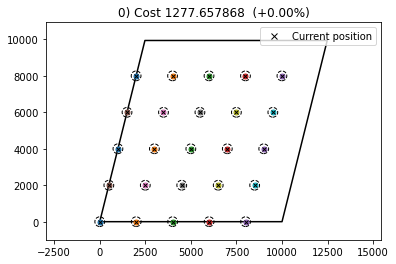

Iteration limit reached    (Exit mode 9)
            Current function value: [-1.28515506e+09]
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	2476.028s


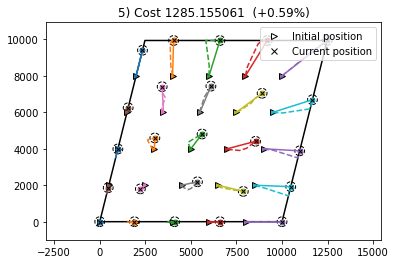

In [11]:
problem = get_problem(5, 1.0)
cost, state, recorder = problem.optimize(disp=True)

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
import matplotlib.pyplot as plt

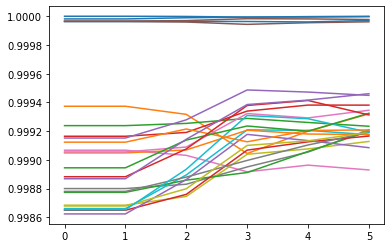

In [25]:
plt.plot(recorder['Tower_base_fore_aft_M_x'])
plt.show()

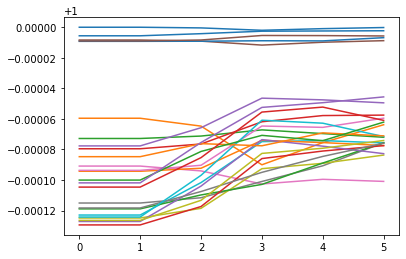

In [26]:
plt.plot(recorder['Blade_root_flapwise_M_x'])
plt.show()

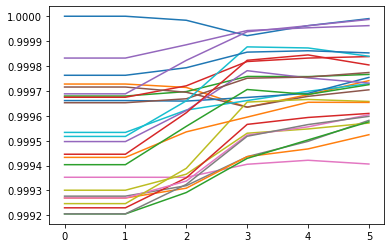

In [28]:
plt.plot(recorder['Blade_root_edgewise_M_y'])
plt.show()

In [19]:
recorder.keys()

['y',
 'x',
 'aggr_cost',
 'Tower_base_fore_aft_M_x',
 'Blade_root_flapwise_M_x',
 'Blade_root_edgewise_M_y',
 'wtSeparationSquared',
 'boundaryDistances',
 'Tower_base_side_side_M_y',
 'post_penalty_Tower_base_fore_aft_M_x',
 'pdf_ik',
 'xy_boundary',
 'Tower_base_fore_aft_M_x_DEL_ik',
 'post_penalty_Tower_base_side_side_M_y',
 'penalty',
 'WS_eff_ik',
 'post_penalty_Blade_root_flapwise_M_x',
 'penalty_xyboundary_comp_convex_hull_44838',
 'TI_eff_ikm',
 'Tower_base_side_side_M_y_DEL_ik',
 'post_penalty_Blade_root_edgewise_M_y',
 'Blade_root_flapwise_M_x_abs',
 'Blade_root_flapwise_M_x_DEL_ik',
 'Blade_root_edgewise_M_y_DEL_ik',
 'plot_counter',
 'penalty_spacing_comp_534',
 'cost',
 'Blade_root_edgewise_M_y_abs',
 'Tower_base_fore_aft_M_x_abs',
 'Cost',
 'Tower_base_side_side_M_y_abs',
 'counter',
 'iteration_coordinate',
 'timestamp',
 'success',
 'msg']

C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

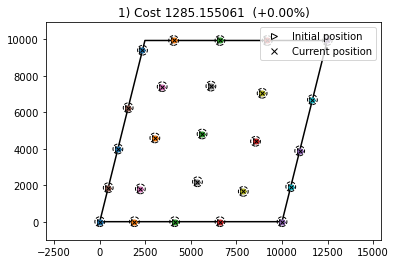

In [12]:
cost, state, recorder = problem.optimize(disp=True, state=state)

## Post Process
During the optimization all variable are recorded. After it is finished one can see all the recorded variables by typing `recorder.keys()` and plot them by writing `plt.plot([your variable],'.')`. We can use this procedure to examine how the load constraint has developed during the optimization:

First we show the relative loads meaning the ratio between the load at each iteration and the initial loads:

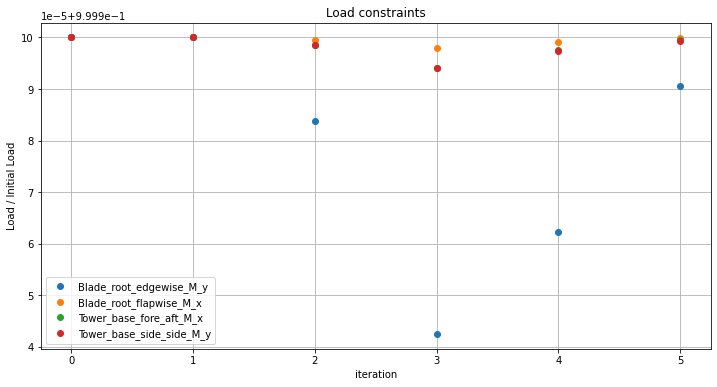

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
for ls in wf.load_signals:
    plt.plot(np.max(recorder[ls], axis=1),'o',label=ls)
plt.grid()
plt.title('Load constraints')
plt.legend(loc='lower left')
plt.ylabel('Load / Initial Load')
plt.xlabel('iteration')
plt.show()

Secondly we can also plot the absolute magnitude of the loads as a function of the iterations:

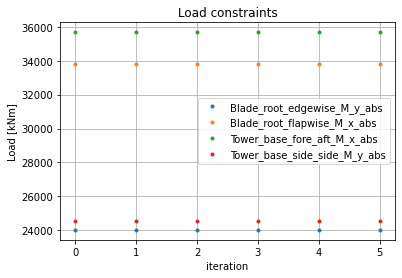

In [40]:
plt.figure()
for ls in wf.load_signals:
    ls += '_abs'
    plt.plot(np.max(recorder[ls], axis=1),'.',label=ls)
plt.grid()
plt.title('Load constraints')
plt.legend()
plt.ylabel('Load [kNm]')
plt.xlabel('iteration')
plt.show()